# Assignment 8 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.3.1 installed. This means, you should be able to use it without any changes to your environment.
If you activate the `gt` environment, as shown at the end of [Assignment 6](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) you can use pytorch version 1.4 and tensorflow 2.1 (not required in this assignment).

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/checkpoints
```

As an aside, since `~/.cache` can contain several folders (e.g. `pip` package downloads) whose size can exceed your quota, it may be a good idea to create a `dotcache` folder in your scratch space and create a symbolic link to it from `~/.cache`.

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [3]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Sat Mar  7 19:14:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 46%   34C    P0    N/A /  75W |    954MiB /  4030MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Here is an example of the training data:**

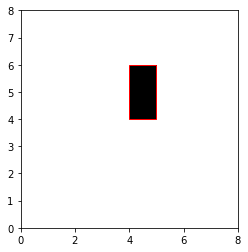

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

#         Input: (∗)(*)(∗) . Input can be of any shape

#         Output: (∗)(*)(∗) . Output is of the same shape as input



display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [24]:
# Reshape and normalize Adadeltathe image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [25]:
#making model in pytorch
model = nn.Sequential(
    nn.Linear(64, 200),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(200, 4),)

if torch.cuda.is_available():
    model = model.cuda()

In [26]:
#using adam optimizer
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [27]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()

In [28]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []

for epoch in range(2000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

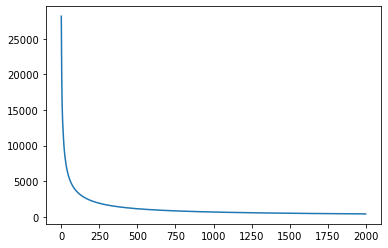

In [29]:
plt.plot(loss_record)

In [30]:
phase = 'test'
# change the model from training to evaluation mode to improve testing performance
model = model.eval()

In [31]:
# Predict bounding boxes on the test images.

pred_y = model(Variable(torch.Tensor(test_X)).cuda())

if torch.cuda.is_available():
    pred_y = pred_y.cuda()    
    
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)

pred_bboxes.shape

(10000, 1, 4)

In [32]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9111487172901176

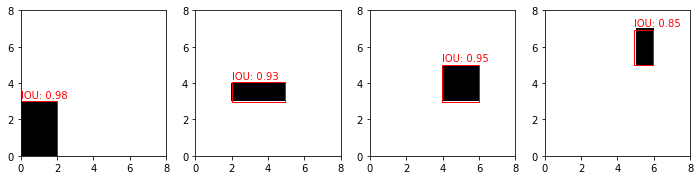

In [33]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

Dropout and Batchnorm function differently during training and eval. During training, dropout randomly makes inputs zero, but during eval we need the entire model to work. This is why model.eval() has a significant impact on the test performance.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup, fill out the answer to Task 2.2 below.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network without the modificiation that you applied in 2.3 above) so that you can detect one out of 1000 classes. Please fill out your the answer to Task 2.4 below.

# Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/tfl_tut.py)

In [56]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

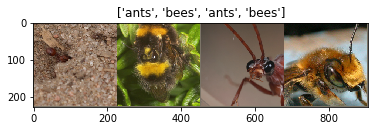

In [40]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [41]:
model_conv = torchvision.models.resnet18(pretrained=True)

### Answer for Task 2.2

In [43]:
#perform your own training
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5210 Acc: 0.7295
val Loss: 0.1787 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4843 Acc: 0.7869
val Loss: 0.4161 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5311 Acc: 0.7787
val Loss: 0.5723 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.5302 Acc: 0.7828
val Loss: 0.2867 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4546 Acc: 0.8115
val Loss: 0.2589 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5854 Acc: 0.7787
val Loss: 0.2616 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3728 Acc: 0.8607
val Loss: 0.3241 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3374 Acc: 0.8525
val Loss: 0.2379 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2510 Acc: 0.8770
val Loss: 0.2390 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3200 Acc: 0.8689
val Loss: 0.2249 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2624 Acc: 0.8770
val Loss: 0.2254 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3132 Acc: 0.8811
val Loss: 0.2107 Acc: 0.9281

Ep

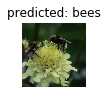

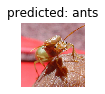

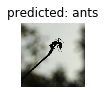

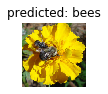

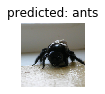

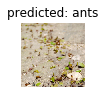

In [44]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [5]:
# changing the last layers of vgg
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1] + [nn.Linear(4096,2)])

vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.3382 Acc: 0.8648
val Loss: 0.1075 Acc: 0.9739

Epoch 1/24
----------
train Loss: 0.2324 Acc: 0.9344
val Loss: 0.0822 Acc: 0.9739

Epoch 2/24
----------
train Loss: 0.2231 Acc: 0.9262
val Loss: 0.1277 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.1680 Acc: 0.9262
val Loss: 0.1416 Acc: 0.9673

Epoch 4/24
----------
train Loss: 0.1123 Acc: 0.9590
val Loss: 0.1930 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.2390 Acc: 0.9221
val Loss: 0.1726 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1390 Acc: 0.9508
val Loss: 0.1614 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.1622 Acc: 0.9467
val Loss: 0.1435 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.1483 Acc: 0.9385
val Loss: 0.1439 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.1181 Acc: 0.9467
val Loss: 0.1434 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1323 Acc: 0.9631
val Loss: 0.1430 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0767 Acc: 0.9672
val Loss: 0.1408 Acc: 0.9542

Ep

In [14]:
#changing the last layers of alexnet
alexnet = torchvision.models.alexnet(pretrained=True) 

for param in squeezenet.parameters():
    param.requires_grad = False


    
alexnet.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1] + [nn.Linear(4096,2)])

alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7331 Acc: 0.6844
val Loss: 0.7867 Acc: 0.5490

Epoch 1/24
----------
train Loss: 0.6474 Acc: 0.6475
val Loss: 0.6617 Acc: 0.6471

Epoch 2/24
----------
train Loss: 0.6428 Acc: 0.6516
val Loss: 0.6577 Acc: 0.6340

Epoch 3/24
----------
train Loss: 0.6332 Acc: 0.6557
val Loss: 0.6403 Acc: 0.7255

Epoch 4/24
----------
train Loss: 0.5989 Acc: 0.6885
val Loss: 0.5585 Acc: 0.7059

Epoch 5/24
----------
train Loss: 0.5405 Acc: 0.7172
val Loss: 0.5563 Acc: 0.7386

Epoch 6/24
----------
train Loss: 0.4001 Acc: 0.8279
val Loss: 0.5989 Acc: 0.7451

Epoch 7/24
----------
train Loss: 0.4245 Acc: 0.8074
val Loss: 0.4375 Acc: 0.8366

Epoch 8/24
----------
train Loss: 0.2840 Acc: 0.8975
val Loss: 0.3807 Acc: 0.8431

Epoch 9/24
----------
train Loss: 0.2290 Acc: 0.9057
val Loss: 0.4293 Acc: 0.8431

Epoch 10/24
----------
train Loss: 0.2139 Acc: 0.9139
val Loss: 0.2988 Acc: 0.8431

Epoch 11/24
----------
train Loss: 0.1790 Acc: 0.9303
val Loss: 0.3176 Acc: 0.8562

Ep

### Answer for Task 2.4

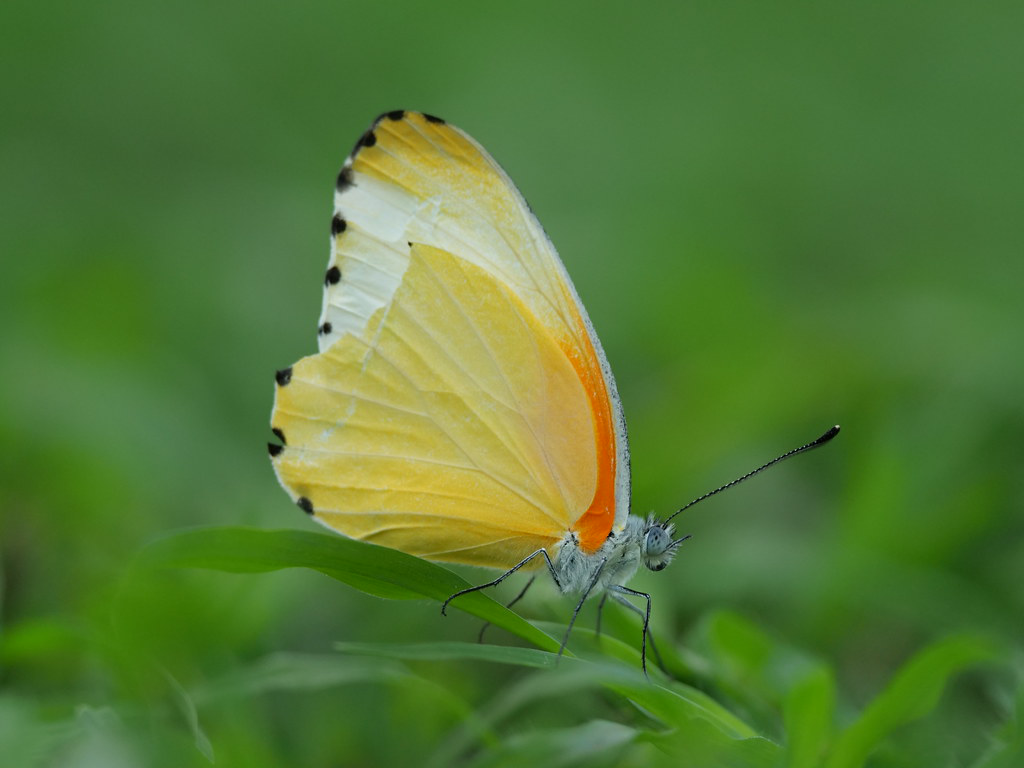

In [52]:
import io
import requests
from PIL import Image


#loading vgg16 pretrained models
vgg16 = models.vgg16(pretrained=True)


Img_dir = 'data/test/test2.jpg'
#giving url for the imagenet labels 1000
LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'


img_pil = Image.open(Img_dir)

img_pil

In [58]:
img_tensor = data_transforms['val'](img_pil)
img_tensor.unsqueeze_(0)

tensor([[[[-0.9363, -0.9363, -0.9363,  ..., -1.0048, -0.9877, -1.0048],
          [-0.9534, -0.9534, -0.9534,  ..., -0.9877, -0.9877, -1.0048],
          [-0.9363, -0.9534, -0.9534,  ..., -0.9877, -0.9877, -1.0048],
          ...,
          [-1.1932, -1.1932, -1.1075,  ..., -0.9363, -0.9363, -0.9192],
          [-1.1932, -1.2103, -1.1589,  ..., -0.9192, -0.9020, -0.8849],
          [-1.2103, -1.2445, -1.2274,  ..., -0.9192, -0.8678, -0.8335]],

         [[-0.0399, -0.0399, -0.0399,  ..., -0.0574, -0.0399, -0.0224],
          [-0.0574, -0.0574, -0.0574,  ..., -0.0399, -0.0399, -0.0224],
          [-0.0399, -0.0574, -0.0574,  ..., -0.0574, -0.0399, -0.0399],
          ...,
          [-0.3725, -0.3725, -0.2850,  ...,  0.0126, -0.0224, -0.0399],
          [-0.3725, -0.3901, -0.3375,  ...,  0.0651,  0.0476,  0.0301],
          [-0.3901, -0.4251, -0.4076,  ...,  0.0651,  0.0651,  0.1001]],

         [[-0.7936, -0.8110, -0.8110,  ..., -0.9156, -0.8981, -0.8981],
          [-0.7936, -0.8284, -

In [59]:
img_variable = Variable(img_tensor)
fc_out = vgg16(img_variable)

In [60]:
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [61]:
print(labels[fc_out.data.numpy().argmax()])

sulphur butterfly, sulfur butterfly


Please include the picture and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb) containing answers to Task 1 and for Task 2 including some portions of the transfer learning tutorial notebook in the sections above corresponding to tasks 2.1 - 2.4.